# 1. Import

In [ ]:
pip install feature_engine


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.datasets import fetch_openml


# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# data preparation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, KBinsDiscretizer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from feature_engine.outliers import Winsorizer
from category_encoders.ordinal import OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_selector

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#visualization
from sklearn import set_config
set_config(display = 'text')
from sklearn.tree import plot_tree


Data obtained from [Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

In [ ]:
# import data
url = 'https://drive.google.com/file/d/197qn4hO4jI-YhPV68ZGoMD0FqQ-OIRzQ/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]

In [ ]:
data = pd.read_csv(path, sep = ';')

# drop 'duration' column to avoid bias
data.drop('duration', axis = 'columns', inplace = True)

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no


# 2 Data exploration and visualization

In [ ]:
# to see the amount of data the dataset contains, its types and the names of columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  campaign   45211 non-null  int64 
 12  pdays      45211 non-null  int64 
 13  previous   45211 non-null  int64 
 14  poutcome   45211 non-null  object
 15  y          45211 non-null  object
dtypes: int64(6), object(10)
memory usage: 5.5+ MB


## 2.1 Categorical data


In [ ]:
# Are there any missing data?
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

It seems that there are no missing data, so there is no need to fill them in.
However, the dataset page claims that there are columns in which one of the possible values is "unknown", which are esentially missing data.

In [ ]:
for feature in data.select_dtypes('object'):
    print('Feature: ',feature, data[feature].unique())

Feature:  job ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
Feature:  marital ['married' 'single' 'divorced']
Feature:  education ['tertiary' 'secondary' 'unknown' 'primary']
Feature:  default ['no' 'yes']
Feature:  housing ['yes' 'no']
Feature:  loan ['no' 'yes']
Feature:  contact ['unknown' 'cellular' 'telephone']
Feature:  month ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
Feature:  poutcome ['unknown' 'failure' 'other' 'success']
Feature:  y ['no' 'yes']


When values in these columns are obsereved, the unknown value appear in the job, education, contact and poutcome columns. Let's see if they form a substantial part of the data.

In [ ]:
# How many people did not provide these information?
data.job.value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

In [ ]:
na_job =len(data.query('job == "unknown"'))/len(data)
print(f'Unknown job is in {na_job:.2%} of the data')

Unknown job is in 0.64% of the data


In [ ]:
data.education.value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

In [ ]:
na_education =len(data.query('education == "unknown"'))/len(data)
print(f'Unknown education is in {na_education:.2%} of the data')

Unknown education is in 4.11% of the data


The proportion of contacted people whose job or education is unknown isrelatively low (0,64 and 4.11 % respectively). 

In [ ]:
df = (
    data
      .pivot_table(data, index = 'contact', columns = 'y', aggfunc = {'contact':'count'})
      .droplevel(0, axis = 1)
    .assign(positive_percent = lambda x: x['yes']/(x['no']+x['yes'])*100)
)
df

y,no,yes,positive_percent
contact,,,
cellular,24916,4369,14.918900
telephone,2516,390,13.420509
unknown,12490,530,4.070661


We can see that the groups that were contacted on cellular and on telephone have a similar proportion of positive responses, while the group about which we do not have this information is less likely to have a positive response. For this reason, the unknown values may be important.

In [ ]:
# how many people were not contacted before
len(data.query('pdays == -1'))

36954

In [ ]:
#outcome of previous campaign distribution
data['poutcome'].value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

In [ ]:
na_poutcome =len(data.query('poutcome == "unknown"'))/len(data)
print(f'Unknown previous outcome is in {na_poutcome:.2%} of the data')

Unknown previous outcome is in 81.75% of the data


As the majority of people were not contacted before, they have unknown value in the outcome of previous call. There are only 5 people who were contacted before and the previous outcome in unknown.

As the job category is has many possible values, let's check if there are any rare values.

In [ ]:
job_percent = (
    data['job']
    .value_counts(normalize = True)
    .mul(100)
)
job_percent   

blue-collar      21.525735
management       20.919688
technician       16.803433
admin.           11.437482
services          9.188029
retired           5.007631
self-employed     3.492513
entrepreneur      3.289023
unemployed        2.882042
housemaid         2.742695
student           2.074716
unknown           0.637013
Name: job, dtype: float64

There are several jobs that do not make much of the dataset. I want to know if there is a pattern in how likely they are to accept the offer.

In [ ]:
df = (
    data
    .pivot_table(index = 'job', columns = 'y', aggfunc={'y': 'count'})
    .droplevel(0, axis = 1)
    .assign(positive_percent = lambda x: x['yes']/(x['no']+x['yes'])*100)
    .assign(job_type_percent = job_percent)
    .sort_values('job_type_percent', ascending = False)
)
df

y,no,yes,positive_percent,job_type_percent
job,,,,
blue-collar,9024,708,7.274969,21.525735
management,8157,1301,13.755551,20.919688
technician,6757,840,11.056996,16.803433
admin.,4540,631,12.202669,11.437482
services,3785,369,8.883004,9.188029
retired,1748,516,22.791519,5.007631
self-employed,1392,187,11.842939,3.492513
entrepreneur,1364,123,8.271688,3.289023
unemployed,1101,202,15.502686,2.882042


From this table, it is visible that there are big differences based on job type in whether the person accepted the offer or not (28% student vs. 8% entrepreneur). For this reason, I will not use RareLabelEncoder.

Note: I tried also RareLabelEncoding the job column but it did not improve the models (they performed slightly worse)

In [ ]:
fig = px.histogram(data, x = 'month', category_orders=dict(month=["may", "jun", "jul", "aug", 'sep', 'oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr']))
fig.show()

As we do not have the data about year of each call, it is not for certain but from this graph we could suppose that in some months, more aggressive campaign were launched - especially in the summer. Adittionaly, the page says that the data are from May 2008 to November 2010, which means that three years of data from May-November are included, while from the other months we do have only two years of data.

In [ ]:
# Pivot table for other categorical columns
categorical = ['marital', 'education', 'default', 'housing', 'loan']

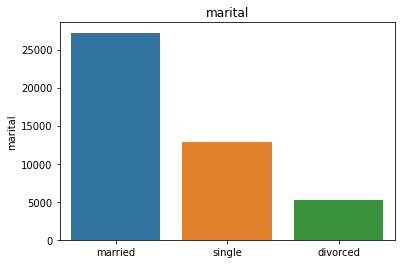

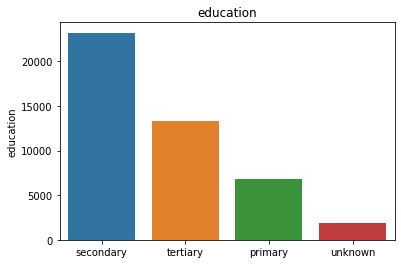

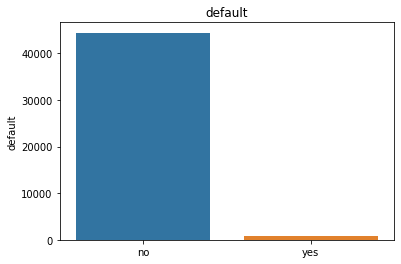

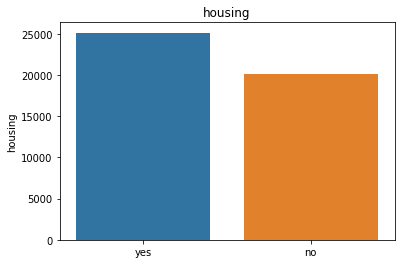

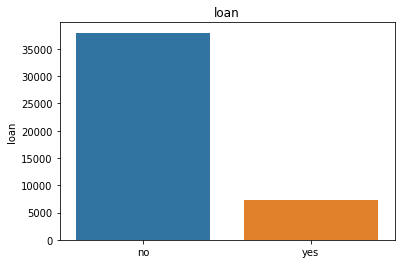

In [ ]:
for i in categorical:
    sns.barplot(x=data[i].value_counts().index, y=data[i].value_counts()).set_title(i)
    plt.show()

In [ ]:
for i in categorical:
    print(pd.pivot_table(data, index = i, columns = 'y', aggfunc = {'y': 'count'}).droplevel(0, axis = 1))
    print()

y            no   yes
marital              
divorced   4585   622
married   24459  2755
single    10878  1912

y             no   yes
education             
primary     6260   591
secondary  20752  2450
tertiary   11305  1996
unknown     1605   252

y           no   yes
default             
no       39159  5237
yes        763    52

y           no   yes
housing             
no       16727  3354
yes      23195  1935

y        no   yes
loan             
no    33162  4805
yes    6760   484



## 2.2 Numerical data

In [ ]:
for i in data.select_dtypes('number').columns:
    fig = px.histogram(data, x=i)
    fig.show()

               age   balance       day  campaign     pdays  previous
age       1.000000  0.097783 -0.009120  0.004760 -0.023758  0.001288
balance   0.097783  1.000000  0.004503 -0.014578  0.003435  0.016674
day      -0.009120  0.004503  1.000000  0.162490 -0.093044 -0.051710
campaign  0.004760 -0.014578  0.162490  1.000000 -0.088628 -0.032855
pdays    -0.023758  0.003435 -0.093044 -0.088628  1.000000  0.454820
previous  0.001288  0.016674 -0.051710 -0.032855  0.454820  1.000000


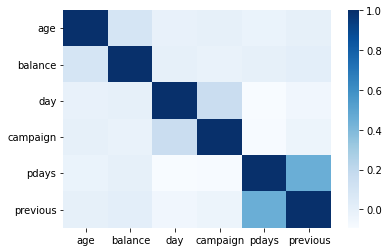

In [ ]:
print(data.select_dtypes('number').corr())
sns.heatmap(data.select_dtypes('number').corr(), cmap = 'Blues')

In [ ]:
data.describe()

,age,balance,day,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,63.000000,871.000000,275.000000


Minimum and maximum values in age, balance, day, and pdays columns do seem reasonable. We do have month and day at our disposal, but no year is provided so it is impossible to convert the data to dates and see if there are patterns regarding to which days there is the most success. Pdays will need to be turned to categorical as there are many people who were not contacted previously.

In [ ]:
# search for outliers in data
data['previous'].value_counts()

0      36954
1       2772
2       2106
3       1142
4        714
5        459
6        277
7        205
8        129
9         92
10        67
11        65
12        44
13        38
15        20
14        19
17        15
16        13
19        11
20         8
23         8
18         6
22         6
24         5
27         5
21         4
29         4
25         4
30         3
38         2
37         2
26         2
28         2
51         1
275        1
58         1
32         1
40         1
55         1
35         1
41         1
Name: previous, dtype: int64

In [ ]:
# the number of contacts in this campaign also contains some higher values
data['campaign'].value_counts()

1     17544
2     12505
3      5521
4      3522
5      1764
6      1291
7       735
8       540
9       327
10      266
11      201
12      155
13      133
14       93
15       84
16       79
17       69
18       51
19       44
20       43
21       35
22       23
25       22
23       22
24       20
29       16
28       16
26       13
31       12
27       10
32        9
30        8
33        6
34        5
36        4
35        4
43        3
38        3
37        2
50        2
41        2
46        1
58        1
55        1
63        1
51        1
39        1
44        1
Name: campaign, dtype: int64

One person was contacted 275 times, which is very strange and very likely an error, and for this reason I will drop this one entry. Also other higher values are rare, and it is unlikely that the bank contacted its clients 40 - 50 times during one campaign. For this reason, I'll use winsorizer for these columns.

In [ ]:
data.drop(data.loc[data['previous'] == 275].index, inplace = True)

# 3 Split Data

In [ ]:
# Split data into train, validation and test parts
X = data.drop(columns = ['y']).copy()
y = data['y']

# filtrate 70 % as train data
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7)

# test and validation data will be 15% each
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
print(X_val.shape), print(y_val.shape)
print(X_test.shape), print(y_test.shape)

(31646, 15)
(31646,)
(6782, 15)
(6782,)
(6782, 15)
(6782,)


(None, None)

# 4 Feature Engineering

In [ ]:
# create list to encode ordinal categories
object_wo_education = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

In [ ]:
# map ordinal values in education
feature_order = [{'col':'education',
                  'mapping': {'unknown':0,'primary':1,'secondary':2,'tertiary':3}
                  }]

In [ ]:
transformer = ColumnTransformer([
         ('dicretization', KBinsDiscretizer(strategy = 'kmeans', encode = 'ordinal'), ['pdays']),
         ('ohe', OneHotEncoder(), object_wo_education),
         ('standard', StandardScaler(), ['age', 'balance', 'day']),
    ('ordinal', OrdinalEncoder(mapping = feature_order,
                               handle_unknown = 'error',
                               handle_missing  = 'error'),
                              ['education']
    ),
         ('winsorizing_and_scaling',
          Pipeline(steps=[
              ('winsorizing', Winsorizer(capping_method = 'quantiles', fold = 0.05, tail = 'right')),
              ('scaling', MinMaxScaler())
          ]), ['previous', 'campaign']
         )
])

In [ ]:
transformer.fit(X_train, y_train)
X_train_transf = transformer.transform(X_train)
X_val_transf = transformer.transform(X_val)
X_test_transf = transformer.transform(X_test)

In [ ]:
# I was not able to get names out the usual way because of the transformer
# This code is the courtesy of pjgao on github forum: https://github.com/scikit-learn/scikit-learn/issues/12525#issuecomment-436217100
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names_out()
        except AttributeError: 
            names = raw_col_name
        if isinstance(names,np.ndarray): 
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

In [ ]:
# assign column names to X_train_transf
column_names = get_column_names_from_ColumnTransformer(transformer)
print(f'No of column names: {len(column_names)}')
print(f'X_train_transf: {X_train_transf.shape}')

No of column names: 45
X_train_transf: (31646, 47)


column names has only 45 values, because the code for obtaining names from ColumnTransformer was not able to obtain names from the pipeline within it. The missing names are previous and campaign, so I'll append them.


In [ ]:
column_names.append('previous')
column_names.append('campaign')
X_train_transf = pd.DataFrame(data = X_train_transf, columns = column_names)

In [ ]:
X_val_transf = pd.DataFrame(data = X_val_transf, columns = column_names)
X_test_transf = pd.DataFrame(data = X_test_transf, columns = column_names)

In [ ]:
# change output values to 1 for yes an 0 for no
y_train = y_train.map({'yes': 1, 'no': 0}).astype(int)
y_val = y_val.map({'yes': 1, 'no': 0}).astype(int)
y_test = y_test.map({'yes': 1, 'no': 0}).astype(int)

# 5 Model Selection

## 5.1 Decision Tree

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train_transf, y_train)

DecisionTreeClassifier()

In [ ]:
dt_scores = cross_validate(estimator = dt, X = X_train_transf, y = y_train, 
                           scoring = ['f1','accuracy','precision'], 
                           return_train_score = True,
                           cv = 3)

In [ ]:
pd.DataFrame(dt_scores)

,fit_time,score_time,test_f1,train_f1,test_accuracy,train_accuracy,test_precision,train_precision
0,0.243640,0.016713,0.302481,1.0,0.832117,1.0,0.292015,1.0
1,0.227288,0.014891,0.307102,1.0,0.828894,1.0,0.289645,1.0
2,0.239052,0.015825,0.304365,1.0,0.829257,1.0,0.288433,1.0


The model is overfitted on training data (precision and accuracy on training data is 100%), so I'll try tuning the hyperparametre ccp_alpha.

In [ ]:
dt_base_grid = {'ccp_alpha': [0.5, 0.1, 0.01, 0.005, 0.001]}
dt_grid = GridSearchCV(dt, dt_base_grid)
dt_grid.fit(X_train_transf, y_train)
print("Best setting discovered: ")
dt_grid.best_estimator_

Best setting discovered: 


DecisionTreeClassifier(ccp_alpha=0.001)

In [ ]:
best_dt = dt_grid.best_estimator_
dt_scores_optimized = cross_validate(estimator = best_dt, X = X_train_transf, y = y_train, 
                           scoring = ['f1','accuracy','precision'], 
                           return_train_score = True,
                           cv = 3)

In [ ]:
pd.DataFrame(dt_scores_optimized)

,fit_time,score_time,test_f1,train_f1,test_accuracy,train_accuracy,test_precision,train_precision
0,0.254862,0.013793,0.312110,0.296018,0.895535,0.893587,0.661376,0.636119
1,0.241228,0.013149,0.297136,0.352560,0.888331,0.895720,0.550885,0.629863
2,0.258634,0.014590,0.323493,0.296690,0.895715,0.893260,0.652605,0.629973


The performance improved and is similar for train and test data, so I'll fit the tree.

In [ ]:
best_dt.fit(X_train_transf, y_train)

DecisionTreeClassifier(ccp_alpha=0.001)

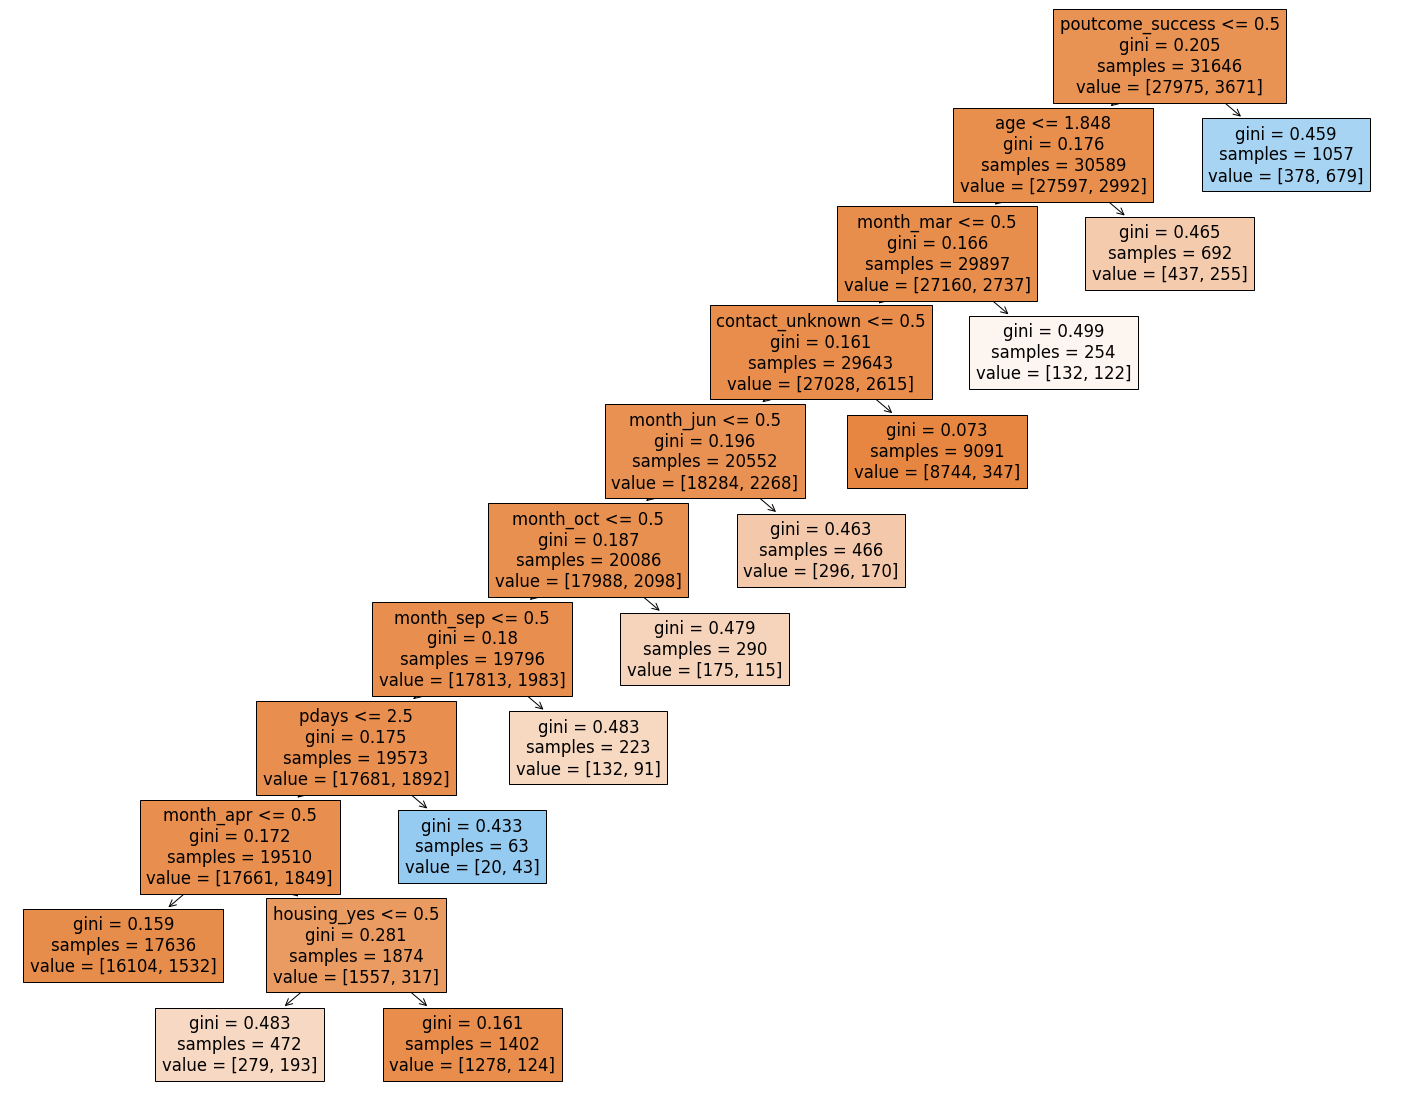

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(best_dt, filled=True, feature_names = X_train_transf.columns)

In [ ]:
# Evaluate the model on validation data
y_train_pred_dt = best_dt.predict(X_train_transf)
y_val_pred_dt = best_dt.predict(X_val_transf)
print("Accuracy on training data: " + str(round(accuracy_score(y_train, y_train_pred_dt), 3)))
print("Accuracy on validation data: " + str(round(accuracy_score(y_val, y_val_pred_dt), 3)))

Accuracy on training data: 0.894
Accuracy on validation data: 0.89


Accuracy is good on both training and validation data, so I won't tune the hyperparameters anymore and I'll try the model on test data.

In [ ]:
y_test_pred_dt = best_dt.predict(X_test_transf)
print("Accuracy on holdout data: " + str(round(accuracy_score(y_test, y_test_pred_dt), 3)))

Accuracy on holdout data: 0.893


## 5.2 Logistic Regression

### 5.2.1 Attribute selection

In [ ]:
# Visualize the correlation between numerical attributes
correlation_matrix = X_train.corr()

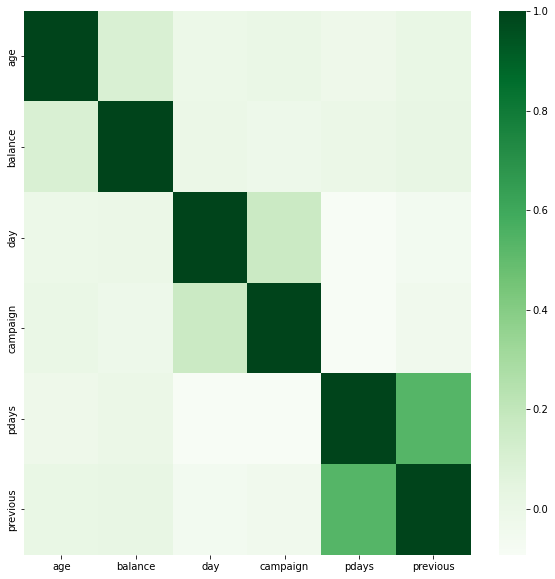

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix, cmap = 'Greens');

The correlation between attributes is not very high, so they are probably informative and I'll keep all of them.

In [ ]:
mutual_info = SelectKBest(score_func = mutual_info_classif, k = 'all')
mutual_info.fit(X_train_transf, y_train)

SelectKBest(k='all',
            score_func=<function mutual_info_classif at 0x7f03318c6050>)

In [ ]:
feature_names = X_train_transf.columns[mutual_info.get_support()]
feature_score = mutual_info.scores_

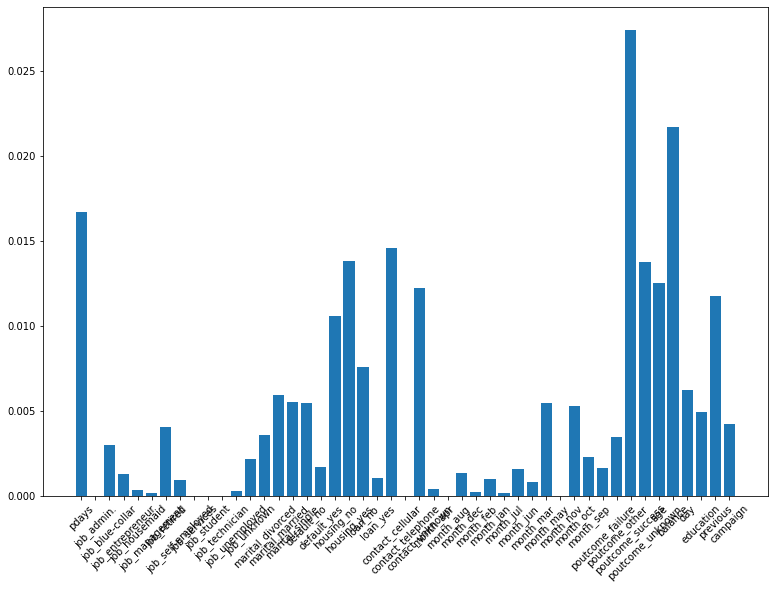

In [ ]:
# Creating a visualization
fig, ax = plt.subplots(figsize = (13,9))
ax.bar(feature_names,feature_score)
plt.xticks(rotation = 45);

In [ ]:
pd.DataFrame(feature_score, index = feature_names, columns = ['score']).query('score >= 0.005')

,score
pdays,0.016712
marital_married,0.005923
marital_single,0.005560
default_no,0.005492
housing_no,0.010592
housing_yes,0.013810
loan_no,0.007624
contact_cellular,0.014574
contact_unknown,0.012221
month_may,0.005499


The attributes that have the biggest score in mutual information are pdays, information about previous loans (default, housing, loan), education, means of contact, and outcome of the previous campaign. Job, education, marital, campaign, do not seem to be significant, so I'll try the model with all attributes as well as without these 4.

### 5.2.2 Model with all attributes creation

In [ ]:
lr = LogisticRegression(penalty='elasticnet',
                        solver='saga',
                        max_iter=10000,
                        l1_ratio=0.5,
                        random_state=42,
                        n_jobs=-1)

In [ ]:
lr.fit(X_train_transf, y_train)

LogisticRegression(l1_ratio=0.5, max_iter=10000, n_jobs=-1,
                   penalty='elasticnet', random_state=42, solver='saga')

In [ ]:
print(f'train accuracy: {lr.score(X_train_transf, y_train):.3}')
print(f'validation accuracy: {lr.score(X_val_transf, y_val):.3}')

train accuracy: 0.894
validation accuracy: 0.892


In [ ]:
lr.intercept_

array([-1.4436627])

In [ ]:
pd.DataFrame(lr.coef_, columns=X_train_transf.columns)

,pdays,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,age,balance,day,education,previous,campaign
0,0.099757,0.0,-0.080813,-0.136123,-0.209304,0.079077,0.430073,-0.028661,-0.029801,0.472276,...,-0.54663,-0.162082,1.72607,-0.124936,0.019624,0.048677,0.039267,0.086071,0.297714,-0.78829


In [ ]:
# predict probability for each row
y_prob = lr.predict_proba(X_train_transf)
# show some data
y_prob[100:110]

array([[0.95954205, 0.04045795],
       [0.94479583, 0.05520417],
       [0.94303028, 0.05696972],
       [0.91264643, 0.08735357],
       [0.90628182, 0.09371818],
       [0.91399783, 0.08600217],
       [0.9256613 , 0.0743387 ],
       [0.98066888, 0.01933112],
       [0.92341323, 0.07658677],
       [0.93968274, 0.06031726]])

In [ ]:
# I'll try different thresholds on my model
threshold = [0.8, 0.7, 0.6, 0.55, 0.50]
for i in threshold:
    y_pred_train = (y_prob[:, 1]>=i).astype(int)
    # accuracy with this threshold
    print(f'Accuracy with threshold {i}: {accuracy_score(y_train, y_pred_train)}')

Accuracy with threshold 0.8: 0.8874423307843013
Accuracy with threshold 0.7: 0.8898754976932314
Accuracy with threshold 0.6: 0.8915502749162612
Accuracy with threshold 0.55: 0.89300385514757
Accuracy with threshold 0.5: 0.8937622448334702


In [ ]:
# It seems that the best model is with the default threshold, so I'll try it's performance on the holdout data
y_test_pred_lr = lr.score(X_test_transf, y_test)
print(f'holdout accuracy: {y_test_pred_lr:.3}')

holdout accuracy: 0.891


### 5.2.3 Logistic regression with only selected features

In [ ]:
# Split data into train, validation and test parts
X_sel = data.drop(columns = ['y', 'job', 'marital', 'campaign', 'education']).copy()
y_sel = data['y']

# filtrate 70 % as train data
X_sel_train, X_sel_rem, y_sel_train, y_sel_rem = train_test_split(X_sel,y_sel, train_size=0.7)

# test and validation data will be 15% each
X_sel_val, X_sel_test, y_sel_val, y_sel_test = train_test_split(X_sel_rem,y_sel_rem, test_size=0.5)

print(X_sel_train.shape), print(y_sel_train.shape)
print(X_sel_val.shape), print(y_sel_val.shape)
print(X_sel_test.shape), print(y_sel_test.shape)

(31646, 11)
(31646,)
(6782, 11)
(6782,)
(6782, 11)
(6782,)


(None, None)

In [ ]:
y_sel_train = y_sel_train.map({'yes': 1, 'no': 0}).astype(int)
y_sel_val = y_sel_val.map({'yes': 1, 'no': 0}).astype(int)
y_sel_test = y_sel_test.map({'yes': 1, 'no': 0}).astype(int)

In [ ]:
# transformer
lr_pipe = Pipeline(steps=[
                          ('lr_trans',
                           ColumnTransformer([
                                              ('dicretization', KBinsDiscretizer(strategy = 'kmeans', encode = 'ordinal'),
                                               ['pdays']),
                                              ('ohe', OneHotEncoder(), make_column_selector(dtype_include = object)),
                                              ('standard', StandardScaler(), ['age', 'balance', 'day']),
                                              ('winsorizing_and_scaling',
                                               Pipeline(steps=[
                                                               ('winsorizing', 
                                                                Winsorizer(capping_method = 'quantiles', 
                                                                           fold = 0.05, 
                                                                           tail = 'right')),
                                                               ('scaling', MinMaxScaler())
                                                                         ]), 
                                               ['previous']
                                               )
                           ])
                          ),
                          ('lr_sel',
                           LogisticRegression(penalty='elasticnet',
                                              solver='saga',
                                              max_iter=10000,
                                              l1_ratio=0.5,
                                              random_state=42,
                                              n_jobs=-1))
])

In [ ]:
lr_pipe.fit(X_sel_train, y_sel_train)

Pipeline(steps=[('lr_trans',
                 ColumnTransformer(transformers=[('dicretization',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   strategy='kmeans'),
                                                  ['pdays']),
                                                 ('ohe', OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f031e0b7090>),
                                                 ('standard', StandardScaler(),
                                                  ['age', 'balance', 'day']),
                                                 ('winsorizing_and_scaling',
                                                  Pipeline(steps=[('winsorizing',
                                                                   Winsorizer(capping_method='quantiles',
                                     

In [ ]:
print(f'train accuracy with selected features only: {lr_pipe.score(X_sel_train, y_sel_train):.3}')
print(f'validation accuracy with selected features only: {lr_pipe.score(X_sel_val, y_sel_val):.3}')

train accuracy with selected features only: 0.893
validation accuracy with selecte features only: 0.891


In [ ]:
print(f'train accuracy: {lr.score(X_train_transf, y_train):.3}')
print(f'validation accuracy: {lr.score(X_val_transf, y_val):.3}')

train accuracy: 0.894
validation accuracy: 0.892


The logistic regression has basically the same performance whether we use all data or not. With selected features only, the performance is slightly better on validation data, so I'll use that model on test data.

In [ ]:
print(f'holdout accuracy: {lr_pipe.score(X_sel_test, y_sel_test):.3}')

holdout accuracy: 0.892


## 5.3 Random Forest

In [ ]:
# I'll use ordinal encoder instead of OneHotEncoder for Random Forest to avoid unbalanced tree
# so I'll create a new transformer

rf_pipe = Pipeline(steps=[
                          ('rf_trans',
                           ColumnTransformer([
                                              ('dicretization', KBinsDiscretizer(strategy = 'kmeans', encode = 'ordinal'),
                                               ['pdays']),
                                              ('ordinal_other', OrdinalEncoder(), object_wo_education),
                                              ('standard', StandardScaler(), ['age', 'balance', 'day']),
                                              ('ordinal', OrdinalEncoder(mapping = feature_order,
                                                                         handle_unknown = 'error',
                                                                         handle_missing  = 'error'),
                                                                             ['education']
                                                   ),
                                              ('winsorizing_and_scaling',
                                               Pipeline(steps=[
                                                               ('winsorizing', 
                                                                Winsorizer(capping_method = 'quantiles', 
                                                                           fold = 0.05, 
                                                                           tail = 'right')),
                                                               ('scaling', MinMaxScaler())
                                                                         ]), 
                                               ['previous', 'campaign']
                                               )
                           ])
                          ),
                          ('rf',
                           RandomForestClassifier())
])


In [ ]:
rf_base_scores = cross_validate(estimator = rf_pipe, X = X_train, y = y_train, 
                           scoring = ['f1','accuracy','precision'], 
                           return_train_score = True,
                           cv = 3)
pd.DataFrame(rf_base_scores)

,fit_time,score_time,test_f1,train_f1,test_accuracy,train_accuracy,test_precision,train_precision
0,2.581107,0.318450,0.318099,0.999591,0.893924,0.999905,0.625899,1.0
1,2.571647,0.300501,0.286567,1.000000,0.886719,1.000000,0.532151,1.0
2,2.577962,0.326203,0.317676,0.999591,0.895336,0.999905,0.650633,1.0


In [ ]:
# Note: I ran various grids to find the best hyperparameters, this was the one which was most useful
# the improvement on test data was very minor in all of the though
default_rf_grid = {
                   'rf__max_depth': [6, 8, 10, 12, 14],
                   'rf__max_samples': [0.5, 0.6, 0.8, 0.9],
                   'rf__max_features': ["log2", "sqrt"],
               }

In [ ]:
grid_rf = GridSearchCV(rf_pipe, default_rf_grid, cv = 3)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('rf_trans',
                                        ColumnTransformer(transformers=[('dicretization',
                                                                         KBinsDiscretizer(encode='ordinal',
                                                                                          strategy='kmeans'),
                                                                         ['pdays']),
                                                                        ('ordinal_other',
                                                                         OrdinalEncoder(),
                                                                         ['job',
                                                                          'marital',
                                                                          'default',
                                                                          'housing',
                   

In [ ]:
grid_rf.best_estimator_

Pipeline(steps=[('rf_trans',
                 ColumnTransformer(transformers=[('dicretization',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   strategy='kmeans'),
                                                  ['pdays']),
                                                 ('ordinal_other',
                                                  OrdinalEncoder(),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome']),
                                                 ('standard', StandardScaler(),
                                                  ['age', 'balance', 'day']),
                                                 ('ordinal',
                                                  OrdinalEncoder(handle_missing='

In [ ]:
rf_best = grid_rf.best_estimator_
rf_best_scores = cross_validate(estimator = rf_best, X = X_train, y = y_train, 
                           scoring = ['f1','accuracy','precision'], 
                           return_train_score = True,
                           cv = 5)
pd.DataFrame(rf_best_scores)

,fit_time,score_time,test_f1,train_f1,test_accuracy,train_accuracy,test_precision,train_precision
0,1.722666,0.133399,0.323061,0.400836,0.899368,0.909425,0.737864,0.860831
1,1.749521,0.133283,0.267530,0.409695,0.892716,0.910534,0.642487,0.873333
2,1.762621,0.129576,0.252700,0.398431,0.890662,0.909112,0.609375,0.858108
3,1.704827,0.130729,0.300107,0.379894,0.896824,0.907414,0.703518,0.851720
4,1.711228,0.134037,0.278618,0.388375,0.894454,0.908559,0.671875,0.866745


In [ ]:
rf_best.fit(X_train, y_train)

Pipeline(steps=[('rf_trans',
                 ColumnTransformer(transformers=[('dicretization',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   strategy='kmeans'),
                                                  ['pdays']),
                                                 ('ordinal_other',
                                                  OrdinalEncoder(),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome']),
                                                 ('standard', StandardScaler(),
                                                  ['age', 'balance', 'day']),
                                                 ('ordinal',
                                                  OrdinalEncoder(handle_missing='

In [ ]:
# Evaluate the model on validation data
y_train_pred_rf = rf_best.predict(X_train)
y_val_pred_rf = rf_best.predict(X_val)
print("Accuracy on training data: " + str(round(accuracy_score(y_train, y_train_pred_rf), 3)))
print("Accuracy on validation data: " + str(round(accuracy_score(y_val, y_val_pred_rf), 3)))

Accuracy on training data: 0.907
Accuracy on validation data: 0.892


In [ ]:
# As I was unable to get a better performance from the random forest despite running several grids, I'll try the test data
y_test_pred_rf = rf_best.predict(X_test)
print("Accuracy on holdout data: " + str(round(accuracy_score(y_test, y_test_pred_rf), 3)))

Accuracy on holdout data: 0.892


# 6 Evaluation

In [ ]:
# Performance of all models on test data
print("Decision Tree accuracy on holdout data: " + str(round(accuracy_score(y_test, y_test_pred_dt), 3)))
print("Random Forest accuracy on holdout data: " + str(round(accuracy_score(y_test, y_test_pred_rf), 3)))
print(f'Logistic Regression accuracy on holdout data: {lr_pipe.score(X_sel_test, y_sel_test):.3}')

Decision Tree accuracy on holdout data: 0.893
Random Forest accuracy on holdout data: 0.892
Logistic Regression accuracy on holdout data: 0.892


All the models have almost the same performance, and it is also quite good, so we can select any of these as our final model.